In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from character.constants import DATA_PATH, FIGURE_PATH

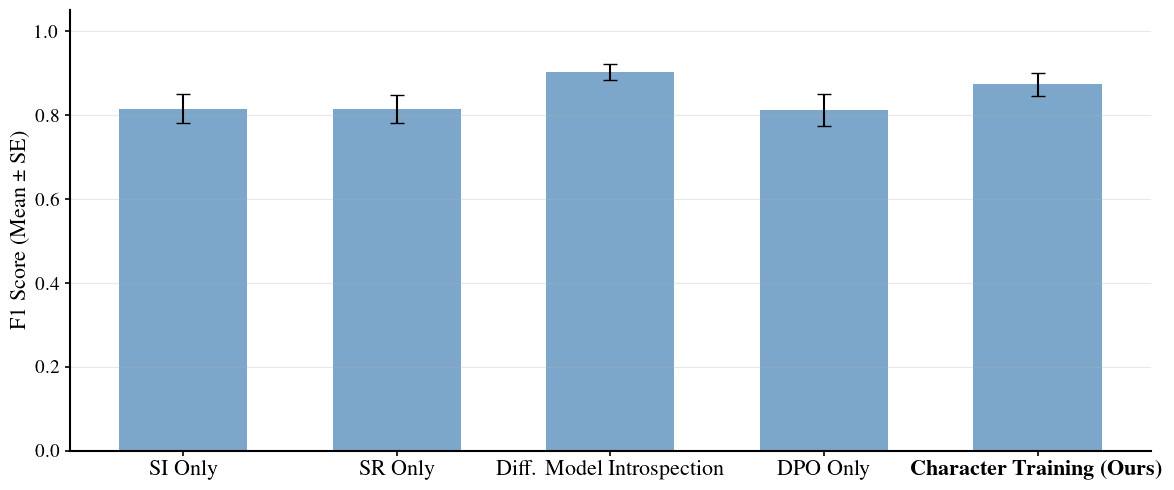

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{newtxtext,newtxmath}",
})

# Ablation plot for Llama 3.1 8B only

plt.figure(figsize=(12, 5))

# Load data for Llama model
PATH_LLAMA = f"{DATA_PATH}/robustness/llama-3.1-8b-it"
f1_llama = pd.read_json(f"{PATH_LLAMA}/f1_ablations.jsonl", orient="records", lines=True)
f1_llama_main = pd.read_json(f"{PATH_LLAMA}/f1.jsonl", orient="records", lines=True)

# Filter ablations data (excluding default and all)
filtered_f1_llama = f1_llama[~f1_llama["variant"].isin(["default", "all"])].copy()

# Get trained_introspection and trained_distillation data from main f1.jsonl
introspection_data = f1_llama_main[
    (f1_llama_main["method"] == "trained_introspection") & 
    (~f1_llama_main["variant"].isin(["default", "all"]))
].copy()

distillation_data = f1_llama_main[
    (f1_llama_main["method"] == "trained_distillation") & 
    (~f1_llama_main["variant"].isin(["default", "all"]))
].copy()

# Combine the data
combined_f1_llama = pd.concat([filtered_f1_llama, introspection_data, distillation_data], ignore_index=True)

# Calculate mean and standard error for each method
summary_stats = combined_f1_llama.groupby(['method'])['score'].agg(['mean', 'sem']).reset_index()

methods = ['trained_interaction', 'trained_reflection', 'trained_qwen', 'trained_distillation', 'trained_introspection']
method_labels = ['SI Only', 'SR Only', 'Diff. Model Introspection', 'DPO Only', r'\textbf{Character Training (Ours)}']
color = 'steelblue'

# Set up bar positions
x = np.arange(len(methods))
width = 0.6

# Get means and sems for each method
means = [summary_stats[summary_stats['method'] == method]['mean'].iloc[0] if len(summary_stats[summary_stats['method'] == method]) > 0 else 0 for method in methods]
sems = [summary_stats[summary_stats['method'] == method]['sem'].iloc[0] if len(summary_stats[summary_stats['method'] == method]) > 0 else 0 for method in methods]

# Create bars
plt.bar(x, means, width, color=color, alpha=0.7, 
        yerr=sems, capsize=5, error_kw={'linewidth': 1.5})

plt.ylim(0, 1.05)
# plt.xlabel('Method of Altering Persona', fontsize=16)
plt.ylabel('F1 Score (Mean ± SE)', fontsize=16, weight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Set x-tick labels
plt.xticks(x, method_labels, fontsize=16, weight='bold')
ax = plt.gca()

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Make remaining spines thicker and darker
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.tick_params(axis='y', labelsize=14, width=1.2, colors='black')
plt.tick_params(axis='x', width=1.2, colors='black')
plt.tight_layout()
outpath = f"{FIGURE_PATH}/robustness_ablations.png"
os.makedirs(os.path.dirname(outpath), exist_ok=True)
plt.savefig(outpath, dpi=400)
plt.show()